# Recommendations with IBM



## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
df.shape

(45993, 3)

In [3]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [4]:
df_content.rename(columns = {'doc_full_name' : 'title'}, inplace = True)

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

Text(0.5, 1.0, 'User Interactions')

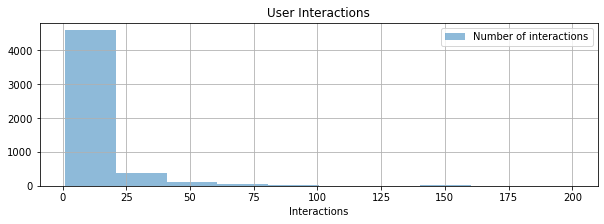

In [5]:
plt.figure(figsize=(10,3))
df.groupby('email').count()['title'].hist(bins = 10,
                                         range = (1, 200),
                                         label = "Number of interactions",
                                         alpha = 0.5);
plt.legend();
plt.xlabel('Interactions');
plt.title('User Interactions')

In [6]:
df['email'].value_counts().describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: email, dtype: float64

In [7]:
# Fill in the median and maximum number of user_article interactios below
median_val = df.groupby('email').count()['title'].median() # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = df.groupby('email').count()['title'].max()# The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [8]:
# Find and explore duplicate articles
df_content.drop_duplicates(subset= ['article_id'],inplace= True)

In [9]:
df_content.shape

(1051, 5)

In [10]:
# Remove any rows that have the same article_id - only keep the first

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [11]:
unique_articles = df['article_id'].value_counts().count()# The number of unique articles that have at least one interaction
total_articles = df_content.shape[0]# The number of unique articles on the IBM platform
unique_users =  df['email'].value_counts().count()# The number of unique users
user_article_interactions = df.shape[0]

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [12]:
most_viewed_article = df.groupby(['article_id']).agg('count')['email'].sort_values(ascending= False).reset_index()[0:1]

In [13]:
most_viewed_article_id = str(most_viewed_article['article_id'][0])# The most viewed article in the dataset as a string with one value following the decimal 
max_views = most_viewed_article['email'][0]# The most viewed article in the dataset was viewed how many times?

In [14]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [15]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [16]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    df_sorted = df.groupby(['title']).agg('count')['user_id'].sort_values(ascending= False).reset_index().head(n)
    top_articles = list(df_sorted['title'])
    
    return top_articles # Return the top article titles from df (not df_content)



In [17]:
def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    df_sorted = df.groupby(['article_id']).agg('count')['user_id'].sort_values(ascending= False).reset_index().head(n)
    top_articles = list(df_sorted['article_id'])
    top_articles = [str(x) for x in top_articles]
    return top_articles # Return the top article ids

In [18]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


In [19]:
def one_zero(x):
    if x >= 1:
        x = 1
    else:
        x=0
    return x

### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [20]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item =df.groupby(['user_id'])['article_id'].value_counts().unstack().fillna(0).applymap(one_zero)
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [21]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [22]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similar_users_dict = {}
    for user in user_item.index:
        similar_users_dict[user] = np.dot(user_item.loc[user_id],
                                     np.transpose(user_item.loc[user]))
    # remove the own user's id
    del similar_users_dict[user_id]    
    
    # sort by similarity
    similar_users_df_sorted = pd.DataFrame.from_dict(similar_users_dict,
                                           orient = 'index').sort_values(0, ascending = False)
    # create list of just the ids
   
    similar_users = list(similar_users_df_sorted.index)
    return similar_users  
    #return most_similar_users # return a list of the users in order from most to least similar
        

In [23]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 46, 4201, 395]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [24]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_list= []
    for item in article_ids:
        article_list.append(df[df.article_id ==float(item)].iloc[0]['title'])
                      
    return article_list   
                      

In [25]:
def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    df_test = user_item[user_item.index== user_id]  
    article_ids = list(df_test.loc[: , (df_test == 1).any()].columns)
    article_names = get_article_names(article_ids, df)
    article_ids = [str(x) for x in article_ids]
    return article_ids, article_names # return the ids and names



In [26]:
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    user_watched_ids = get_user_articles(user_id, user_item)[0]
    recs = []
    for sim_user in find_similar_users(user_id, user_item):
        sim_user_art_id = get_user_articles(sim_user, user_item)[0]
        new_recs = np.setdiff1d(sim_user_art_id,
                                   user_watched_ids)
        recs.extend(np.setdiff1d(new_recs, recs))
    
        if len(recs) >= m:
            break
    recs =  [str(x) for x in recs[:m]]    
    return recs[:m]
    
    return recs # return your recommendations for this user_id    


In [27]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze facebook data using ibm watson and watson studio',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings']

In [28]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [29]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    similar_users_dict = {}
    for user in user_item.index:
        similar_users_dict[user] = np.dot(user_item.loc[user_id],
                                     np.transpose(user_item.loc[user]))
    # remove the own user's id
    del similar_users_dict[user_id]    
    
    # sort by similarity
    similar_users_df = pd.DataFrame.from_dict(similar_users_dict,
                        orient = 'index')
    similar_users_df.columns = ['similarity']
    similar_users_df.index.rename('user_id', inplace=True)
    df_interactions = df.groupby('user_id').count()['title'].to_frame(name = "num_interactions")
    df_sim_interactions = pd.merge(similar_users_df, df_interactions, on='user_id')
    neighbors_df = df_sim_interactions.sort_values(['similarity','num_interactions'], ascending = False)
    
    return neighbors_df # Return the dataframe specified in the doc_string


In [30]:
def sort_articles_by_popularity(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    sorted_articles - (list) list of article ids sorted by the number of 
                    interactions
    '''

    sorted_articles = list(df[df['article_id'].isin(article_ids)].groupby('article_id').count().sort_values('title', ascending = False).index)

    return sorted_articles

In [31]:
df_sorted = df.groupby(['article_id']).agg('count')['user_id'].sort_values(ascending= False).reset_index()
df_sorted.head()
top_articles = list(df_sorted['article_id'])

In [32]:
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    user_watched_ids = get_user_articles(user_id, user_item)[0]
    recs = []
    neighbors_df = get_top_sorted_users(user_id, df, user_item)
    for neighbor in list(neighbors_df.index):
        #access articles that the neighbor watched
        neighbor_art_id = get_user_articles(neighbor, user_item)[0]
        #remove articles that the user has already seen
        recs_to_add_ids = np.setdiff1d(neighbor_art_id,
                                           user_watched_ids)
        recs_to_add_ids = np.setdiff1d(recs_to_add_ids, recs)
           #sort the remaining articles by popularity
        recs_to_add_ids = sort_articles_by_popularity(recs_to_add_ids, df)
        
        #add ids that were not already in the recs
        recs.extend(recs_to_add_ids)
        
        #break if reached enough recommedations
        if len(recs) >= m:
            break
    recs = recs[:m] 
    rec_names = get_article_names(recs, df)
    return recs, rec_names
     

In [33]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0, 1354.0, 1368.0]

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [34]:
### Tests with a dictionary of results
user1_most_sim = get_top_sorted_users(1, df=df, user_item=user_item).index[0]# Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131, df=df, user_item=user_item).index[9]# Find the 10th most similar user to user 131


In [35]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

As the new user hasn't interacted with any articles yet, we cannot determinde which other users are similar. Thus, we are limited to rank-bases recommendations. We can use the functions get_top_articles() and get_top_article_ids to get some initial recommendations.


`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [36]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10, df)# Your recommendations here


In [37]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [38]:
from sklearn.metrics.pairwise import linear_kernel
import nltk
nltk.download(['punkt','wordnet','stopwords'])
import scipy.sparse
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import re

[nltk_data] Downloading package punkt to C:\Users\Monja
[nltk_data]     Burkard\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Monja
[nltk_data]     Burkard\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Monja
[nltk_data]     Burkard\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
def tokenize(text):
    """ Tokenization function that processes the text data """
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    words = word_tokenize(text)
    tokens = [w for w in words if w not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)
    return clean_tokens


In [40]:
df_description = df_content[['article_id', 'title','doc_description']]
df_description=df_description.dropna()


In [41]:
def find_similar_articles(article_id, n = 5, df = df_description):
    '''
    INPUT
    article_id - an article_id 
    n - number of recommendations
    df - dataframe with 'article_id' and 'title'
    OUTPUT
    similar_articles - an array of the most similar articles by title - based on the description
    '''
    count_vect = CountVectorizer(tokenizer = tokenize)
    df_count = count_vect.fit_transform(df_description['doc_description']) # = X
    tfidf_transformer = TfidfTransformer()
    df_tfidf = tfidf_transformer.fit_transform(df_count)

    # compute similarity_matrix
    cosine_sim = linear_kernel(df_tfidf,df_tfidf)
    
    
    indices = pd.Series(df_description.index, index=df['article_id']).drop_duplicates()
    # Get the index of the article that matches the title
    idx = indices[article_id]
    # Get the pairwsie similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    # Sort the articles based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores for 10 most similar articles
    sim_scores = sim_scores[1:n+1]
    # Get the artcicle indices
    article_indices = [i[0] for i in sim_scores]
    similar_article_ids = list(df_description['article_id'].iloc[article_indices].values)
    similar_article_titles = list(df_description['title'].iloc[article_indices].values)
    
    # Return the top 10 most similar movies
    return similar_article_ids, similar_article_titles

In [42]:
def make_content_recs(user_id, n=5,df=df_description):
    '''
    INPUT:
    user_id - user_id to provided recs to
    n - number of recommendations
    OUTPUT
    recs - a dictionary with keys of the user and values of the recommendations
    
    '''
    
    recs = []
    #get ids of articles that the user already read
    user_watched_ids = get_user_articles(user_id, user_item)[0]

    #loop through the watched articles
    for article in user_watched_ids:
        #access similar articles
        
        similar_articles_ids = find_similar_articles(float(article),5,df_description)[0]

        #remove articles that the user has already seen
        recs_to_add_ids = np.setdiff1d(similar_articles_ids,
                                           user_watched_ids)
        recs_to_add_ids = np.setdiff1d(recs_to_add_ids, recs)

        #add ids that were not already in the recs
        recs.extend(recs_to_add_ids)
        
        #break if reached enough recommedations
        if len(recs) >= n:
            break
    recs = recs[:n] #only m recs needed
    rec_names = get_article_names(recs, df_description)
    return recs, rec_names

In [43]:
make_content_recs(1, n=5,df=df_description)

([18, 29, 164, 641, 939],
 ['The Greatest Public Datasets for AI – Startup Grind',
  'Experience IoT with Coursera',
  'Learn TensorFlow and Deep Learning Together and Now!',
  'Perform sentiment analysis with LSTMs, using TensorFlow',
  'Deep Learning From Scratch I: Computational Graphs'])

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

This recommender system is based on the article descriptions. In order to decide how similar one descriptio is to another, I first represented each description text as a vector using TF-IDF. The similarity itself was calculated using cosine similarity (Note that I used linear_kernel instead of cosine_similarity for performance reasons). 

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [44]:
# make recommendations for a brand new user

get_top_articles(5, df=df)


['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm']

In [45]:
# make a recommendations for a user who only has interacted with article id '1427.0'
1427.0 in df_description.article_id

False

Unfortunately, the article with id 1427 doesn't have a description and it's not possible to compare it with descriptions of other articles. In this case, the user would be treated as a new user.

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [46]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [47]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [48]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

Singular Value Decomposition won't work if the matrix has missing values. This was the case in the lesson, when we dealt with ratings. If a user didn't rate a movie, the value was missing. However, in the current case, the question is if a user has interacted with a movie (value is 1) or not (value is 0). So, there are no missing value and we are fine to use SVD with our user-item_matrix.


`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

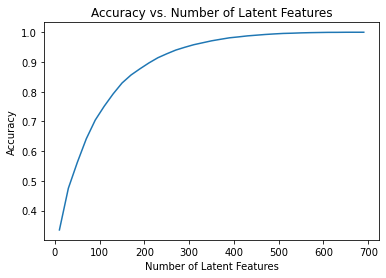

In [49]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    error = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(error)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [50]:
df_train = df.head(40000)
df_test = df.tail(5993)

In [51]:
def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the train dataframe 
    user_item_test - a user-item matrix of the test dataframe 
    test_idx - test user ids
    test_arts - test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [52]:
common_users= set(test_idx).intersection(list(user_item_train.index))
common_users_idx = list(common_users)
len(common_users_idx)


20

In [53]:
len(set(test_idx)) - len(common_users_idx)

662

In [54]:
common_articles = set(test_arts).intersection(list(user_item_train.columns))
common_articles_idx = common_articles
len(common_articles_idx)

574

In [55]:
len(set(test_arts)) - len(common_articles_idx)

0

In [56]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?':b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [57]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below

In [58]:

user_item_test_subset = user_item_test.loc[common_users, common_articles]

new_user_item_train = user_item_train.reset_index()
users_common_idx = list(new_user_item_train[new_user_item_train['user_id'].isin(common_users)].index)

vt_test = vt_train[:, user_item_train.columns.isin(test_arts)]
u_test = u_train[users_common_idx, :]
u_test.shape, vt_test.shape
s_test =s_train[user_item_train.columns.isin(test_arts)]

In [59]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs_train = []
sum_errs_test = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new_t, u_new_t, vt_new_t = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
            
    s_new_tt, u_new_tt, vt_new_tt = np.diag(s_test[:k]), u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_est_t = np.around(np.dot(np.dot(u_new_t, s_new_t), vt_new_t))
    user_item_est_tt = np.around(np.dot(np.dot(u_new_tt, s_new_t), vt_new_tt))
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_est_t)
    diffs_test = np.subtract(user_item_test_subset, user_item_est_tt)
    
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    sum_errs_train.append(err_train)
    
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_test.append(err_test)

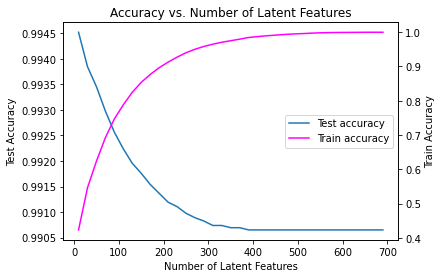

In [60]:

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(num_latent_feats, 1 - np.array(sum_errs_test)/df.shape[0], label="Test accuracy");
ax2.plot(num_latent_feats, 1 - np.array(sum_errs_train)/df.shape[0], color = 'magenta', label="Train accuracy");

handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()

ax1.legend(handler1+handler2, label1+label2, loc='center right')

ax1.set_xlabel('Number of Latent Features');
ax2.set_ylabel('Train Accuracy');
ax1.set_ylabel('Test Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

As one can see in the chart above, the accuracy increases as the number of latent features increases. One reason for that could be the rather low number of common users in train and test datasets. A complex model with many latent features but few data points is prone to overfitting.
However, one should note that accuracy is not be the best metric to assess the model's performance. Accuracy is a suitable metrics if the dataset is balanced. In our case, there is a class imbalance of 1's and 0's, so a better option would be the F1 score (which is to be preferred if we want an optimal relationship between precision and recall). 

Besides the possibility of collecting more data and retraining the model, one could as well implement A/B testing. In order to do that, one could randomly assign users to a control group (e.g., by the user ID) that receive additional new recommendations. A useful metric would be to track 
 the number of articles read per recommended article per user - compared to the predictions of the selected algorithms.

In [61]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

1

In [63]:
!pip freeze > requirements.txt